# Aspect aware clustering demo

Demonstrate and test functions defined in 'aa_cluster.py'

In [1]:
import regex, os, sys
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegressionCV

from ThoughtGraph import ThoughtGraph, tg_utils
from aa_cluster import *
from text_patterns import patterns

N_CLUSTERS = 200
SEED = 0

DATA_FILE = "dolly_pos_clusters_5gram.parquet"
MODELS_FILE = "positive_and_negative_reweighting_models.pickle"

FP_TYPE = 'float32'

framework_flags = ['identify', 'how_does', 'why_is', 'what is', 'extract',
       'of_the_following', 'given_text', 'alternatives', 'output_format']

flag_category_map = {k: 'framework' if k in framework_flags else 'domain' for k in patterns.keys()}
flag_category_map

{'cars': 'domain',
 'animals': 'domain',
 'food': 'domain',
 'programming_language': 'domain',
 'sports': 'domain',
 'science': 'domain',
 'science_fiction': 'domain',
 'data_science': 'domain',
 'information_technology': 'domain',
 'books': 'domain',
 'identify': 'framework',
 'how_does': 'framework',
 'why_is': 'framework',
 'what is': 'framework',
 'extract': 'framework',
 'of_the_following': 'framework',
 'given_text': 'framework',
 'alternatives': 'framework',
 'output_format': 'framework'}

In [2]:
instruction_data = pd.read_parquet(DATA_FILE)[['instruction', 'category', 'instruction_vector']] # 'pos_tfidf_PCs'
instruction_data['instruction_vector'] = [v.astype(FP_TYPE) for v in instruction_data['instruction_vector']]
instruction_data['unit_vector'] = to_unit_vectors(instruction_data['instruction_vector'])

# instruction_data['unit_vector'][0].dtype  # 'float32'

In [3]:
dendro = get_cluster_dendrogram(instruction_data['unit_vector'])

pattern_flags = find_pattern_flags_in_text(instruction_data['instruction'], patterns)

if os.path.exists(MODELS_FILE):
    my_models = pickle.load(open(MODELS_FILE, "rb"))
else:
    my_models = train_pattern_models(instruction_data['instruction_vector'], pattern_flags, verbose=True)
    pickle.dump(my_models, open(MODELS_FILE, "wb"))
    
pattern_scores = get_model_scores_for_vectors(instruction_data['instruction_vector'], my_models)

mean_xval_auc = get_model_mean_xval_auc(my_models)

cluster_assignment_df = get_cluster_assignments(dendro)

cluster_performance_df = get_cluster_performance_df(cluster_assignment_df, pattern_flags, flag_category_map)
                                           
cluster_performance_df

,num_clusters,mean_entropy,mean_purity,roc,auc,flag,cluster_col,flag_category
0,2,0.145423,0.966330,"{'fpr': [0.0, 0.5881174438687392, 1.0], 'tpr':...",0.576277,cars,A,domain
1,4,0.126685,0.971654,"{'fpr': [0.0, 0.5069430051813472, 0.7011398963...",0.598428,cars,B,domain
2,8,0.125725,0.971096,"{'fpr': [0.0, 0.23986183074265977, 0.345215889...",0.656383,cars,C,domain
3,16,0.138608,0.962432,"{'fpr': [0.0, 0.0037996545768566492, 0.0432469...",0.740410,cars,D,domain
4,32,0.121326,0.969315,"{'fpr': [0.0, 0.0037996545768566492, 0.0225215...",0.779616,cars,E,domain
...,...,...,...,...,...,...,...,...
147,16,0.080791,0.962132,"{'fpr': [0.0, 0.01491013071895425, 0.054806644...",0.886755,output_format,D,framework
148,32,0.059065,0.977764,"{'fpr': [0.0, 0.01491013071895425, 0.032815904...",0.895834,output_format,E,framework
149,64,0.050857,0.986641,"{'fpr': [0.0, 0.0009531590413943355, 0.0149101...",0.919168,output_format,F,framework
150,128,0.044666,0.988322,"{'fpr': [0.0, 0.0009531590413943355, 0.0098039...",0.943158,output_format,G,framework


In [4]:
# print(cluster_performance_df)
cluster_performance_df

,num_clusters,mean_entropy,mean_purity,roc,auc,flag,cluster_col,flag_category
0,2,0.145423,0.966330,"{'fpr': [0.0, 0.5881174438687392, 1.0], 'tpr':...",0.576277,cars,A,domain
1,4,0.126685,0.971654,"{'fpr': [0.0, 0.5069430051813472, 0.7011398963...",0.598428,cars,B,domain
2,8,0.125725,0.971096,"{'fpr': [0.0, 0.23986183074265977, 0.345215889...",0.656383,cars,C,domain
3,16,0.138608,0.962432,"{'fpr': [0.0, 0.0037996545768566492, 0.0432469...",0.740410,cars,D,domain
4,32,0.121326,0.969315,"{'fpr': [0.0, 0.0037996545768566492, 0.0225215...",0.779616,cars,E,domain
...,...,...,...,...,...,...,...,...
147,16,0.080791,0.962132,"{'fpr': [0.0, 0.01491013071895425, 0.054806644...",0.886755,output_format,D,framework
148,32,0.059065,0.977764,"{'fpr': [0.0, 0.01491013071895425, 0.032815904...",0.895834,output_format,E,framework
149,64,0.050857,0.986641,"{'fpr': [0.0, 0.0009531590413943355, 0.0149101...",0.919168,output_format,F,framework
150,128,0.044666,0.988322,"{'fpr': [0.0, 0.0009531590413943355, 0.0098039...",0.943158,output_format,G,framework


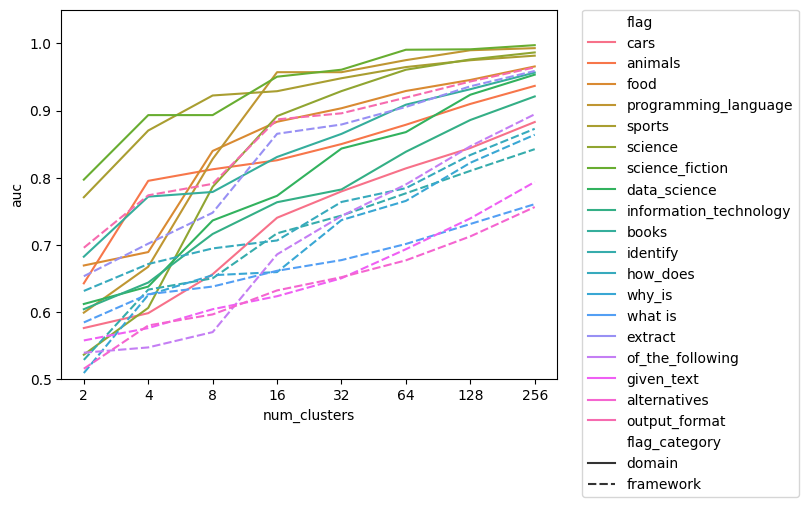

In [5]:
# cluster_performance_df = get_cluster_performance_df(cluster_assignment_df, pattern_flags, flag_category_map)

my_cluster_performance = cluster_performance_df.copy()
framework_flags = ['identify', 'how_does', 'why_is', 'what is', 'extract',
       'of_the_following', 'given_text', 'alternatives', 'output_format']

my_cluster_performance

plot_cluster_performance(my_cluster_performance)

# num_cluster_levels = [str(x) for x in sorted(set(my_cluster_performance['num_clusters']))]

# num_cluster_str = [str(x) for x in my_cluster_performance['num_clusters']]

# my_cluster_performance['num_clusters'] = pd.Series(
#     pd.Categorical(
#         num_cluster_str, categories=num_cluster_levels, ordered=True
#     )
# )

# print(my_cluster_performance.dtypes)

# my_cluster_performance

# metric = 'auc'
# sns.lineplot(x='num_clusters', y=metric, data=my_cluster_performance, hue='flag')


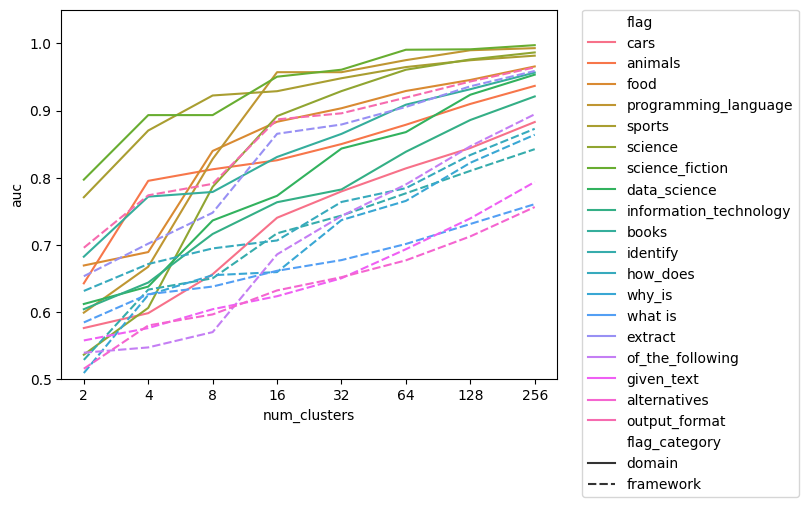

In [6]:
plot_cluster_performance(cluster_performance_df, metric='auc')

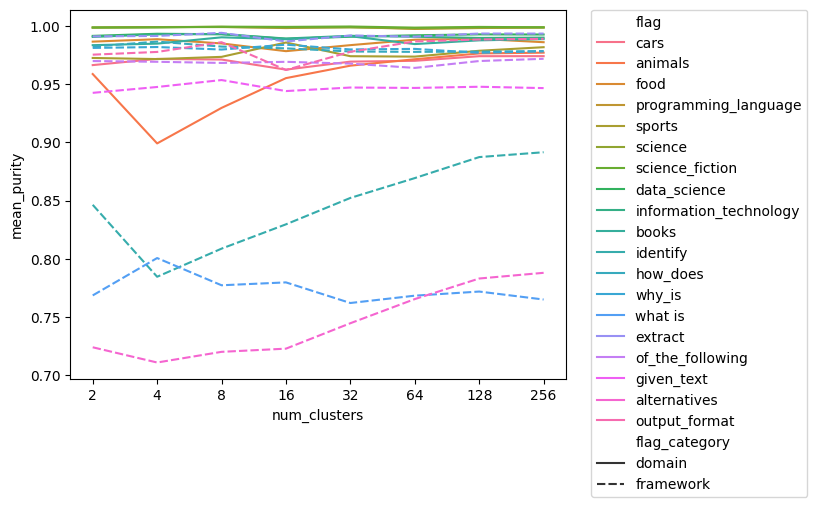

In [7]:
plot_cluster_performance(cluster_performance_df, metric='mean_purity')

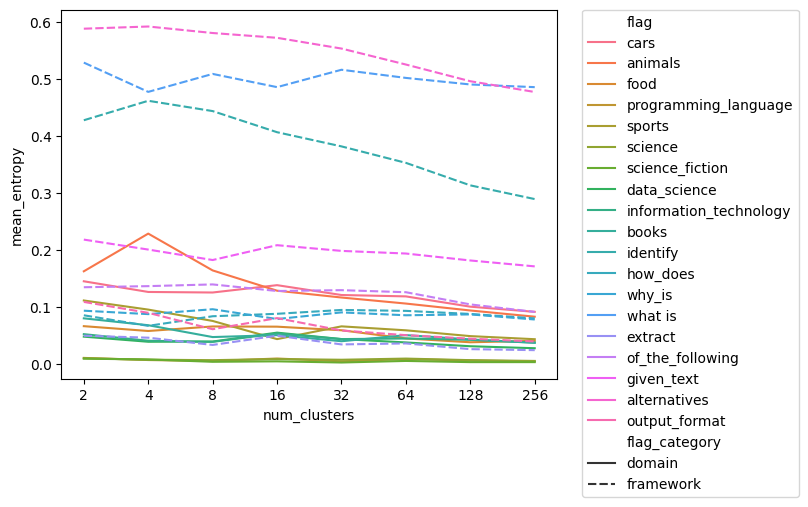

In [8]:
plot_cluster_performance(cluster_performance_df, metric='mean_entropy')

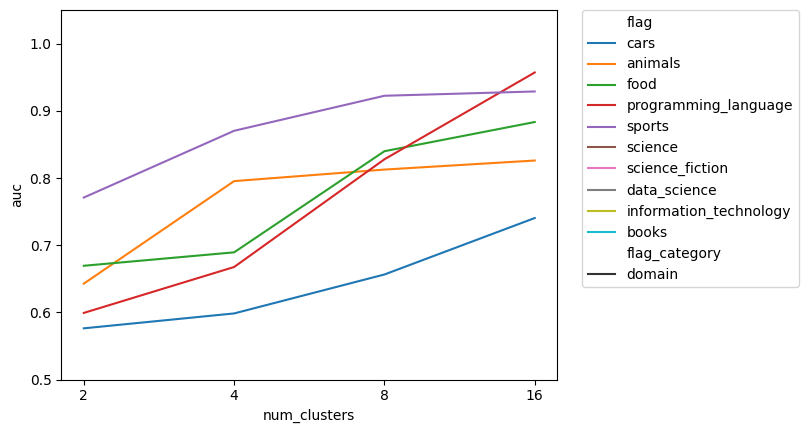

In [9]:
abcd = cluster_performance_df[ [cc in ['A', 'B', 'C', 'D'] for cc in cluster_performance_df['cluster_col'] ] ]

plot_cluster_performance(abcd[ [f not in framework_flags for f in abcd['flag']] ])

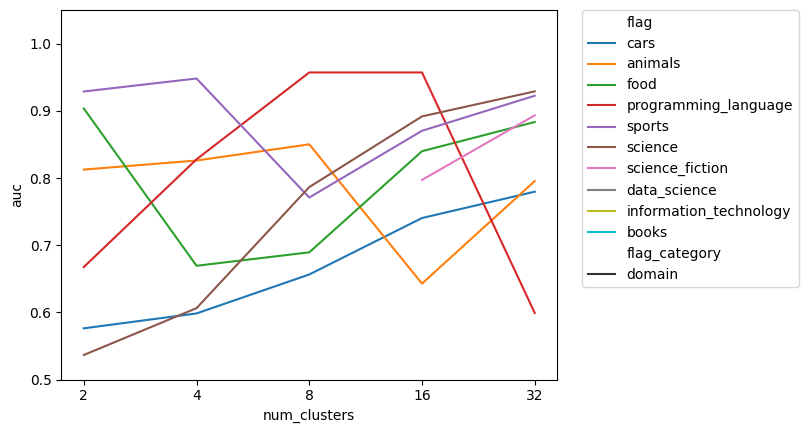

In [10]:
abcde = cluster_performance_df[ [cc in ['A', 'B', 'C', 'D', 'E'] for cc in cluster_performance_df['cluster_col'] ] ]

plot_cluster_performance(abcde[ [f not in framework_flags for f in abcde['flag']] ])

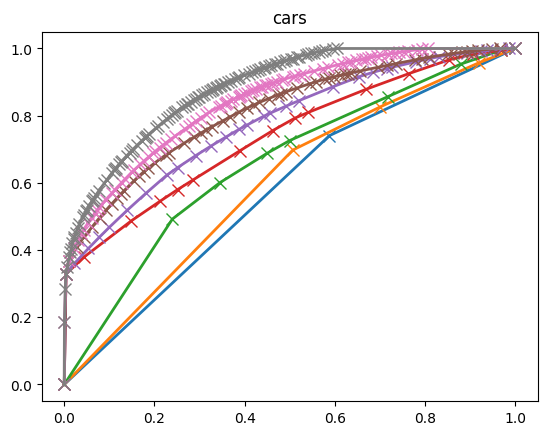

8 ['0.576', '0.598', '0.656', '0.740', '0.780', '0.814', '0.844', '0.883']


In [11]:
plot_aspect_roc_curves('cars', cluster_performance_df)

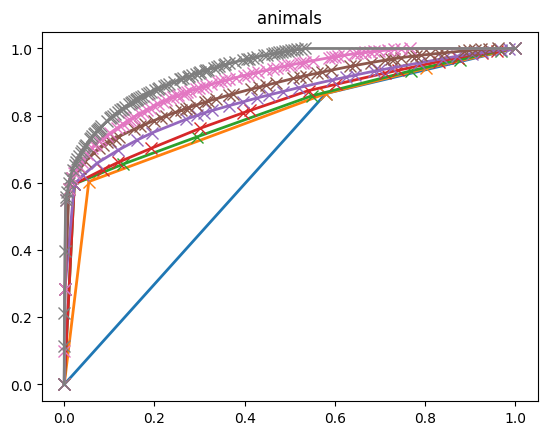

8 ['0.643', '0.795', '0.813', '0.826', '0.850', '0.879', '0.910', '0.937']


In [12]:
plot_aspect_roc_curves('animals', cluster_performance_df)

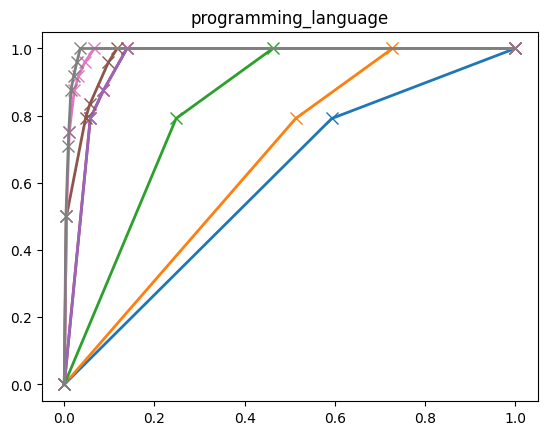

8 ['0.599', '0.668', '0.828', '0.957', '0.957', '0.975', '0.990', '0.993']


In [13]:
plot_aspect_roc_curves('programming_language', cluster_performance_df)

# Where is the red curve?

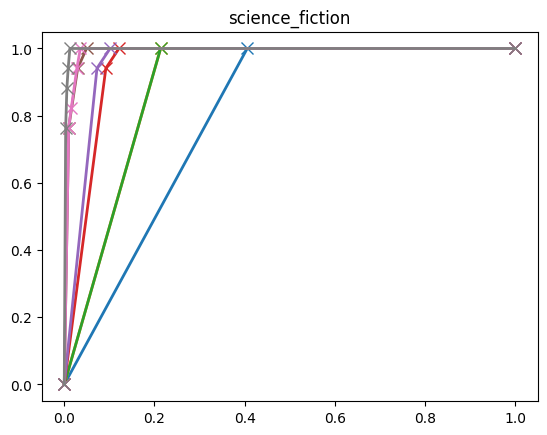

8 ['0.797', '0.893', '0.893', '0.950', '0.961', '0.990', '0.991', '0.997']


In [14]:
plot_aspect_roc_curves('science_fiction', cluster_performance_df) # science

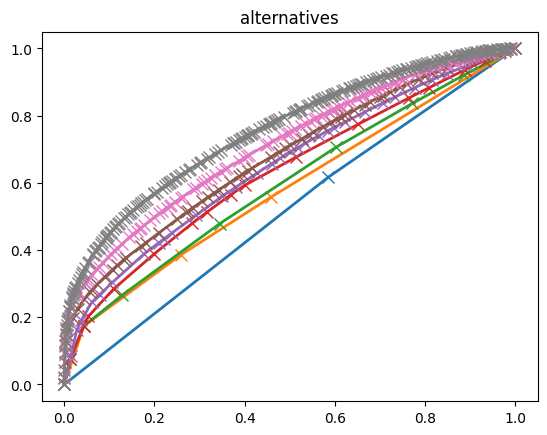

8 ['0.516', '0.580', '0.597', '0.632', '0.652', '0.677', '0.713', '0.756']


In [15]:
plot_aspect_roc_curves('alternatives', cluster_performance_df)

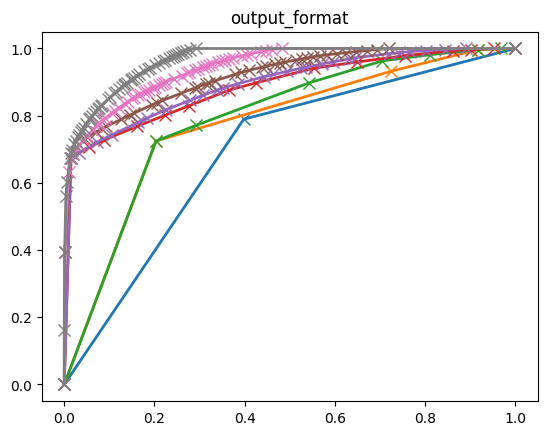

8 ['0.696', '0.774', '0.791', '0.887', '0.896', '0.919', '0.943', '0.964']


In [16]:
plot_aspect_roc_curves('output_format', cluster_performance_df)

# Re-weight embeddings

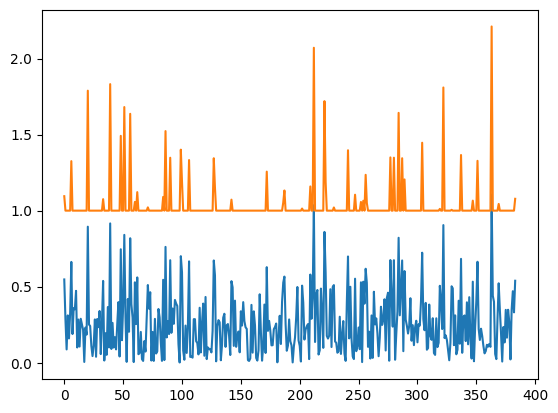

In [17]:
mean_framework_coefs = np.mean([ my_models[flag].coef_[0] for flag in framework_flags ], axis=0)
plt.plot(np.abs(mean_framework_coefs))

adjustment_vector = [ 1 if x<1 else x for x in 2*np.abs(mean_framework_coefs) ]

plt.plot(adjustment_vector)

In [18]:
# my_modifier = my_models['animals'].coef_.astype(FP_TYPE)

# projection = np.array([ get_projection(emb, mean_framework_coefs) for emb in instruction_data['unit_vector'] ])
# projection.shape  # (15011, 384)

In [19]:
# def plot_cluster_aucs(my_cluster_aucs, title='', file=''):
#     """
#     Plot cluster AUC vs. cluster size, from the data returned by 'extract_cluster_aucs'

#     usage:
#         cluster_rocs = get_cluster_performance_df(cluster_assignment_df, pattern_flags, flag_category_map)
#         plot_cluster_aucs(cluster_aucs)

#     """
#     ax = sns.lineplot(x='num_clusters', y='auc', data=my_cluster_aucs, hue='flag')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#     plt.title(title)
#     plt.ylim(0.5, 1.05)
#     ax.set_xscale('log')
#     if file != '':
#         plt.savefig(file)

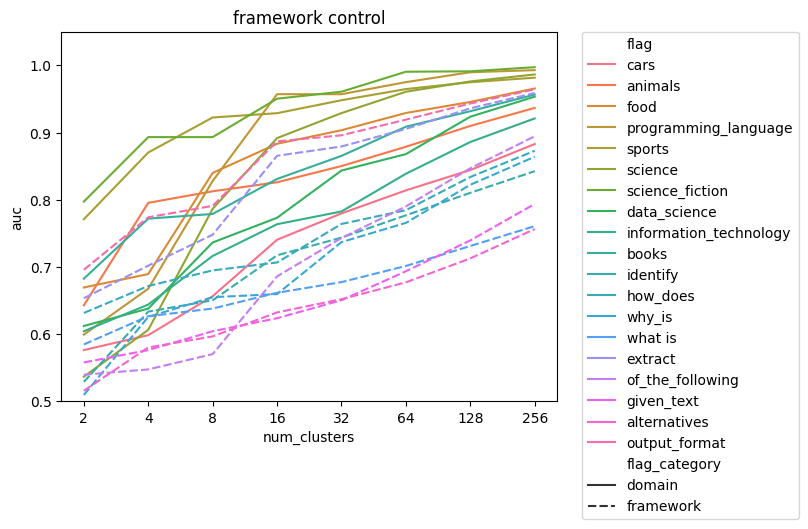

In [20]:
ctl_dendro = get_cluster_dendrogram(instruction_data['unit_vector'])

ctl_cluster_assignment_df = get_cluster_assignments(ctl_dendro, num_slices=8)

ctl_cluster_performance_df = get_cluster_performance_df(ctl_cluster_assignment_df, pattern_flags, flag_category_map)

plot_cluster_performance(ctl_cluster_performance_df, title="framework control", file='auc_framework_control.png')

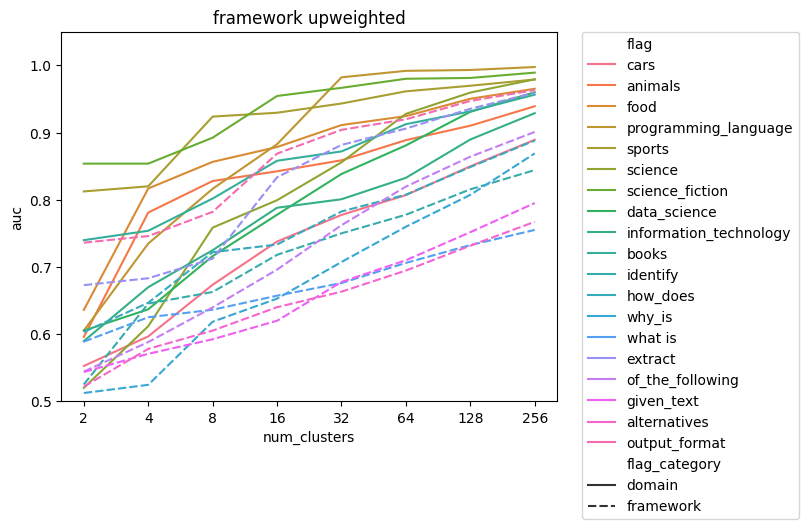

In [21]:
# alpha = 1
# upweighted_embedding = [emb + alpha * prj for emb, prj in zip(instruction_data['unit_vector'], projection)]

upweighted_embedding = [emb * adjustment_vector for emb in instruction_data['unit_vector'] ]

uw_dendro = get_cluster_dendrogram(upweighted_embedding)

uw_cluster_assignment_df = get_cluster_assignments(uw_dendro, num_slices=8)

uw_cluster_performance_df = get_cluster_performance_df(uw_cluster_assignment_df, pattern_flags, flag_category_map)

plot_cluster_performance(uw_cluster_performance_df, title="framework upweighted", file='auc_framework_upweighted_adj.png')

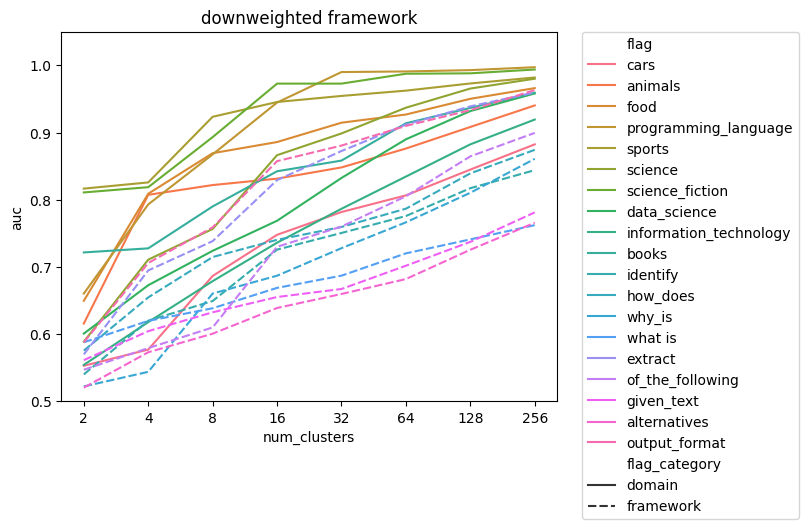

In [22]:
# alpha = -1

downweighted_embedding = [emb / adjustment_vector for emb in instruction_data['unit_vector']]
                        
dw_dendro = get_cluster_dendrogram(downweighted_embedding)

dw_cluster_assignment_df = get_cluster_assignments(dw_dendro, num_slices=8)

dw_cluster_performance_df = get_cluster_performance_df(dw_cluster_assignment_df, pattern_flags, flag_category_map)

plot_cluster_performance(dw_cluster_performance_df, title="downweighted framework", file='auc_framework_downweighted_adj_inv.png')

upweighted framework


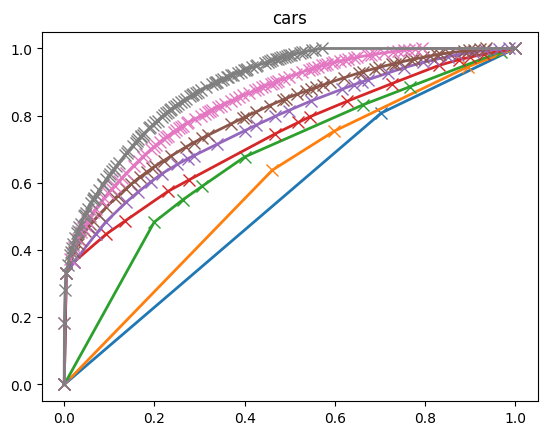

8 ['0.553', '0.597', '0.673', '0.738', '0.777', '0.807', '0.850', '0.889']
control (unweighted)


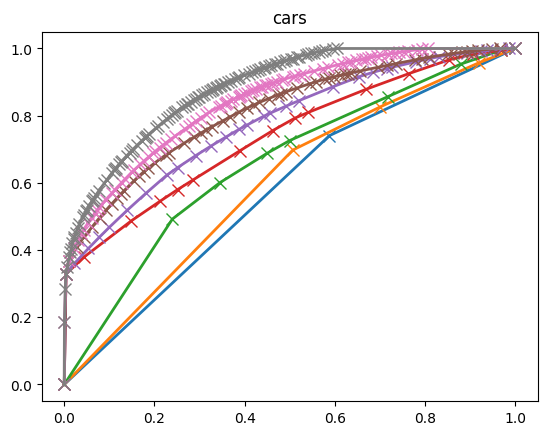

8 ['0.576', '0.598', '0.656', '0.740', '0.780', '0.814', '0.844', '0.883']
downweighted framework


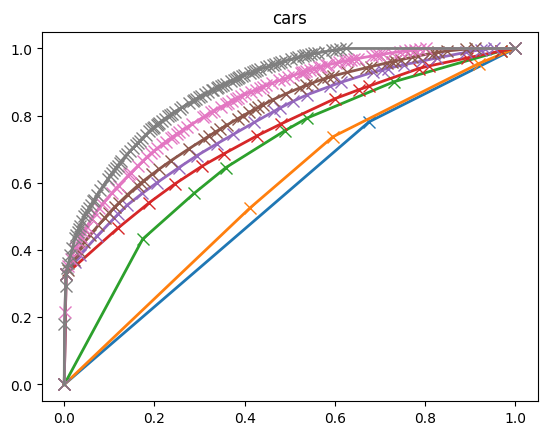

8 ['0.553', '0.577', '0.687', '0.748', '0.782', '0.806', '0.845', '0.882']


In [23]:
my_topic = 'cars'
print('upweighted framework')
plot_aspect_roc_curves(my_topic, uw_cluster_performance_df)

print('control (unweighted)')
plot_aspect_roc_curves(my_topic, ctl_cluster_performance_df)

print('downweighted framework')
plot_aspect_roc_curves(my_topic, dw_cluster_performance_df)

# In Progress

## Improved strip plots

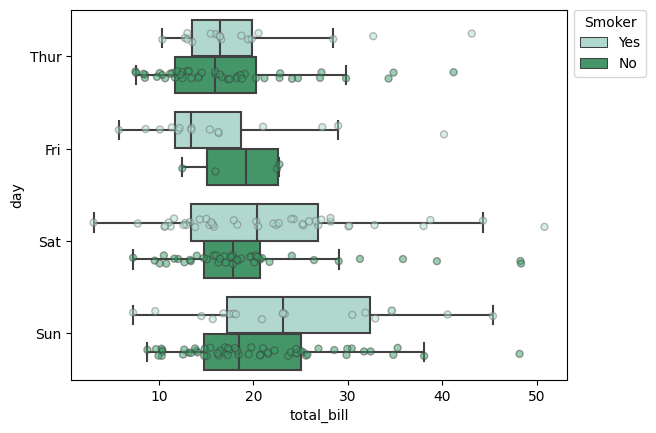

In [24]:
import seaborn as sns

# load the dataframe
tips = sns.load_dataset('tips')

common_params = {'y': "day", 'x': "total_bill", 'hue': "smoker", 'data': tips, 'palette': "BuGn"}
ax = sns.boxplot(fliersize=0, **common_params)

# add stripplot with dodge=True
sns.stripplot(dodge=True, ax=ax, ec='k', linewidth=1, alpha=0.5, **common_params)

# remove extra legend handles and place legend outside bbox
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Smoker', bbox_to_anchor=(1, 1.02), loc='upper left')


(-0.05, 1.05)

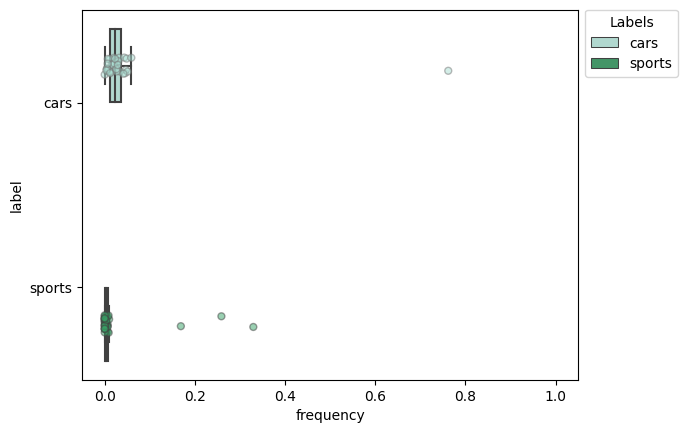

In [25]:

clusterings = cluster_assignment_df[['E', 'F']]
flags_df = pattern_flags[['cars', 'sports']]
cfdf = clusterings.join(flags_df)

ccol = clusterings.columns[0]
cluster_frequencies = cfdf[[ccol, *flags_df.columns]].groupby(ccol).mean().reset_index()

cf_long = pd.melt(cluster_frequencies, id_vars=ccol, var_name='label', value_name='frequency')
cf_long

common_params = {'y': "label", 'x': "frequency", 'hue': "label", 'data': cf_long, 'palette': "BuGn"}
ax = sns.boxplot(fliersize=0, **common_params)

# add stripplot with dodge=True
sns.stripplot(dodge=True, ax=ax, ec='k', linewidth=1, alpha=0.5, **common_params)

# remove extra legend handles and place legend outside bbox
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Labels', bbox_to_anchor=(1, 1.02), loc='upper left')

plt.xlim(-0.05,1.05)


## Upgrading ROC curves

In [26]:

# Modify `plot_aspect_roc_curves` to use a specified color spectrum. We want to represent multiple sets of ROC curves in the same plot with
# a distinguishable spectrum for each plot.
# Order clusters by p-value from binomial distribution?

reds = hue_spectrum(8, hue=0, saturation=1)
print("reds =", reds)

blues = hue_spectrum(8, hue=2/3, saturation=1)
print("blues =", blues)

reds = <list_reverseiterator object at 0x000002A27F0F6470>
blues = <list_reverseiterator object at 0x000002A27F0F6440>


In [27]:
# Rank clusters by cumulative probability of seeing at least that many positives.
# For each cluster, n = size, p = overall prevalence of positive labels

from scipy.stats import binom

n = 10    # number of trials
p = 0.5  # probability of success in each trial
x = [k for k in range(n+1)] # probability of this many successes or fewer

pdf = pd.DataFrame({'successes': x, 'pmf': binom.pmf(x, n, p), 'cdf': binom.cdf(x, n, p)})
pdf['cdf2'] = np.cumsum(pdf['pmf'])
pdf
# binom.cdf(0, n, p)
# 0.5**8 # 0.00390625

,successes,pmf,cdf,cdf2
0,0,0.000977,0.000977,0.000977
1,1,0.009766,0.010742,0.010742
2,2,0.043945,0.054688,0.054688
3,3,0.117187,0.171875,0.171875
4,4,0.205078,0.376953,0.376953
5,5,0.246094,0.623047,0.623047
6,6,0.205078,0.828125,0.828125
7,7,0.117187,0.945312,0.945312
8,8,0.043945,0.989258,0.989258
9,9,0.009766,0.999023,0.999023


In [28]:
# text_col = 'instruction'
# for pattern_name in patterns:
#     flag_vector = [bool(regex.search(patterns[pattern_name], sent, regex.IGNORECASE)) for sent in instruction_data[text_col]]
#     instruction_data[f"{pattern_name}_flag"] = flag_vector
#     print(pattern_name, sum(flag_vector))

# class WeightableClustering():
#     """A single text vector can have multiple embeddings, each of which can be used for multiple clusterings."""
#     def __init__(self, text_list):
#         self.text = text_list
#         self.embeddings = {}    # key = name, value=list of embedding vectors
#         self.ClusterTrees = {}  # key = descriptor, value = ClusterTree object

#     def add_embedding(self, embedding_name, embedding_obj):
#         self.embeddings[embedding_name] = embedding_obj

# class ClusterTree():

#     def __init__(self, text_list):
#         self.embedding = []   # embedding vectors
#         self.dendrograms = {}  # key = descriptor, value = ClusterTree object

# from scipy.cluster.hierarchy import ward, fcluster
# from scipy.spatial.distance import pdist
# import math

# # cluster by the sentence vectors
# vector_list = instruction_data['unit_vector'].tolist()
# D = pdist(vector_list, metric='cosine') # condensed pairwise distance matrix
# dendro = ward(D) # linkage matrix representing a dendrogram [cl1, cl2, distance, size of merged cluster)

# cluster_assignments = [] # list of dicts: {num_cluters, cluster_ids}
# for num_clusters in [10, 20, 40, 80, 160, 320]:
#     cluster_ids = fcluster(dendro, num_clusters, criterion='maxclust')
#     cluster_assignments.append({'num_clusters': num_clusters, 'cluster_ids': cluster_ids})

# zdf = pd.DataFrame(z, columns=['c1', 'c2', 'd', 'n'])
# zdf[zdf['c1'] < 2]